# COVID-19 cases by country

JHU dataset: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv


Population by country, United Nations.
http://data.un.org/Data.aspx?q=world+population&d=PopDiv&f=variableID%3a12%3bcrID%3a900

Selected: 2019 and "zero migration"


In [1]:
# Plots inline with the code
%matplotlib inline

# Data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Libraries to read data from web downloads and generate a dataframe
import requests
from io import StringIO


In [2]:
# Sets the notebook to use the full width of the window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

## Datasets

* Grab the new data via HTTPS
* Transform the awkward table into column format with a section for each country
* Group by country
* Count number of days since first reported case

In [3]:
url_prefix = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
# Get data via github
# Transform awkward JHU table
def get_jhu_dataset(data_file):
    # Get the latest updates from JHU via github
    data_web = requests.get('{}{}'.format(url_prefix, data_file), allow_redirects=True)
    data_io = StringIO(data_web.text)
    df = pd.read_csv(data_io)
    df.drop(['Long', 'Lat'], axis=1, inplace=True)

    # Break the akward table into sections for each country
    df_list = list()
    for c in set(df['Country/Region']):
        country = c
        totals = df[df['Country/Region'] == country].sum()
        daily_new_cases = totals[2:].diff()
        # Place back first row
        daily_new_cases[0] = totals[2]
        df_country = pd.DataFrame(daily_new_cases)
        df_country = df_country.rename(columns={0:'daily_new_cases'})
        df_country['country'] = country
        df_list.append(df_country)
        
    # Put all sections of countries into a single dataframe
    df_all = pd.concat(df_list)
    df_all = df_all.reset_index().rename(columns={'index':'date'})
    df_all = df_all[df_all['daily_new_cases'] > 0]
    df_all['date'] = pd.to_datetime(df_all['date'])
    return df_all


pop_df = pd.read_csv('UNdata_Export_20200413_043146356.zip')
def get_population(country):
    if country == 'US':
        country = 'United States of America'
    return int(pop_df[pop_df['Country or Area'].str.contains(country)]['Value'].iloc[0] * 1000)


In [26]:
def get_topN_by_total(df, number_countries):
    groups =  df.groupby('country')
    top_n = list(groups['daily_new_cases'].sum().sort_values(ascending=False).keys()[0:number_countries])
    return top_n

# Group by country
# Count days since first reported case
rolling_avg_window = 7
def get_country(df, c):
    population = get_population(c)/1000000 # Calculates per Million inhabitants
    first_case = df[df['country'] == c]['date'].min()
    days_since_first_case = df[df['country'] == c]['date'] - first_case
    country_df = pd.DataFrame()
    country_df['days_since_first_case'] = days_since_first_case
    country_df['new_cases'] =  np.int64(df[df['country'] == c]['daily_new_cases'])
    country_df['new_cases_pop'] = country_df['new_cases']/population
    country_df['new_cases_avg'] = country_df['new_cases'].rolling(rolling_avg_window).mean()
    country_df['new_cases_pop_avg'] = country_df['new_cases_pop'].rolling(rolling_avg_window).mean()
    country_df['new_cases_acc'] = country_df['new_cases'].diff()
    country_df['new_cases_acc_pct'] = country_df['new_cases'].pct_change()
    country_df['new_cases_acc_pop'] = country_df['new_cases'].diff()/population
    country_df['new_cases_avg_acc'] = country_df['new_cases_avg'].diff()
    country_df['new_cases_avg_acc_pct'] = country_df['new_cases_avg'].pct_change()
    country_df['new_cases_avg_acc_pop'] = country_df['new_cases_avg'].diff()/population

    total_cases = country_df['new_cases'].sum()
    country_df['Country'] = '{}: {:,}'.format(c, total_cases)
    country_df['Date'] = df[df['country'] == c]['date'] 
    print('{}: {}'.format(c, total_cases))
    return country_df

def get_topN_countries(df, top_n_countries):
    #top_n_countries = get_topN_by_total(df, number_countries)
    n = len(top_n_countries)
    topN_df = df[df['country'].isin(top_n_countries)]
    df_list = list()
    for c in top_n_countries:
        df_list.append(get_country(df, c))

    countries_df = pd.concat(df_list, ignore_index=True)
    countries_df['days_since_first_case'] = countries_df['days_since_first_case'].dt.days
    return countries_df



In [27]:
def plot_country(country_df, x_label=None, y_label=None):
    if x_label is not None:
        new_x_label = x_label
    else:
        new_x_label = 'days_since_first_case'
    if y_label is not None:
        new_y_label = y_label
    else:
        new_y_label = 'new_cases'
        
    plot_df = country_df.rename(columns={'days_since_first_case':new_x_label, 'new_cases':new_y_label})
        
    sns.set(style="ticks")
    with sns.axes_style("darkgrid"):
        grid = sns.FacetGrid(plot_df, col="Country", hue='Country', col_wrap=1, height=3)
        g = grid.map(plt.plot, new_x_label, new_y_label)
        #g = grid.map(plt.fill_between, new_x_label, new_y_label, alpha=0.2)#.set_titles("{col_name}")
        


def plot_grid(countries_df, col_wrap=4, x_label=None, y_label=None, colname='new_cases'):
    if x_label is not None:
        new_x_label = x_label
    else:
        new_x_label = 'days_since_first_case'
    if y_label is not None:
        new_y_label = y_label
    else:
        new_y_label = 'new_cases'
        
    plot_df = countries_df.rename(columns={'days_since_first_case':new_x_label, colname:new_y_label})
        
    sns.set(style="ticks")
    with sns.axes_style("darkgrid"):
        grid = sns.FacetGrid(plot_df, col="Country", hue='Country', col_wrap=col_wrap, height=3)
        g = grid.map(plt.plot, new_x_label, new_y_label)
        g = grid.map(plt.fill_between, new_x_label, new_y_label, alpha=0.2).set_titles("{col_name}")
        


# Confirmed cases

In [28]:
confirmed_df = get_jhu_dataset('time_series_covid19_confirmed_global.csv')
# Get top N by total count.  xWe'll use that for other plots
topN_countries_by_total = get_topN_by_total(confirmed_df, 12)
confirmed_countries_df = get_topN_countries(confirmed_df, topN_countries_by_total)


US: 667801
Spain: 184948
Italy: 168941
France: 147091
Germany: 137698
United Kingdom: 104145
China: 83403
Iran: 77995
Turkey: 74193
Belgium: 34809
Canada: 30808
Brazil: 30425


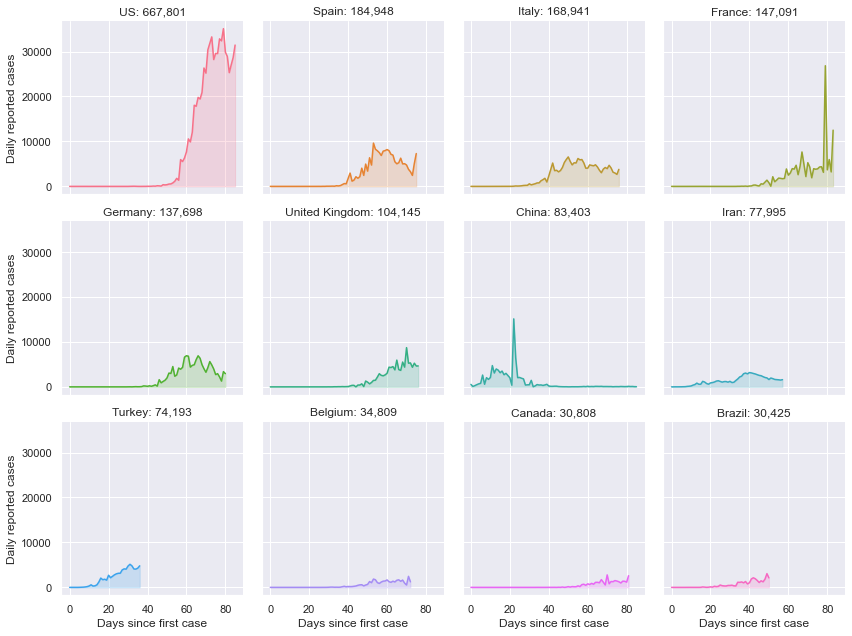

In [7]:
# New daily cases
plot_grid(confirmed_countries_df, x_label='Days since first case', y_label='Daily reported cases')


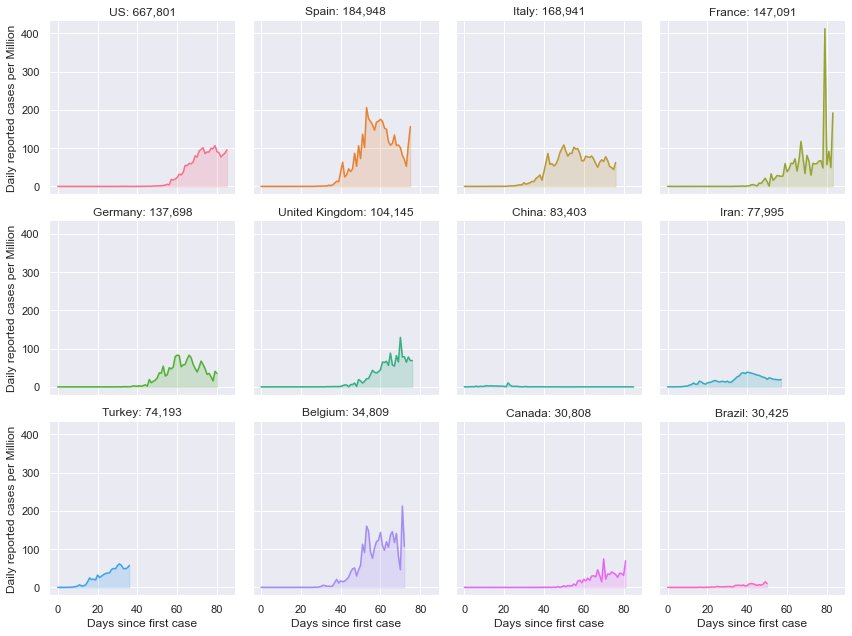

In [8]:
# New daily cases per Million inhabitants
plot_grid(confirmed_countries_df, x_label='Days since first case', y_label='Daily reported cases per Million', colname='new_cases_pop')


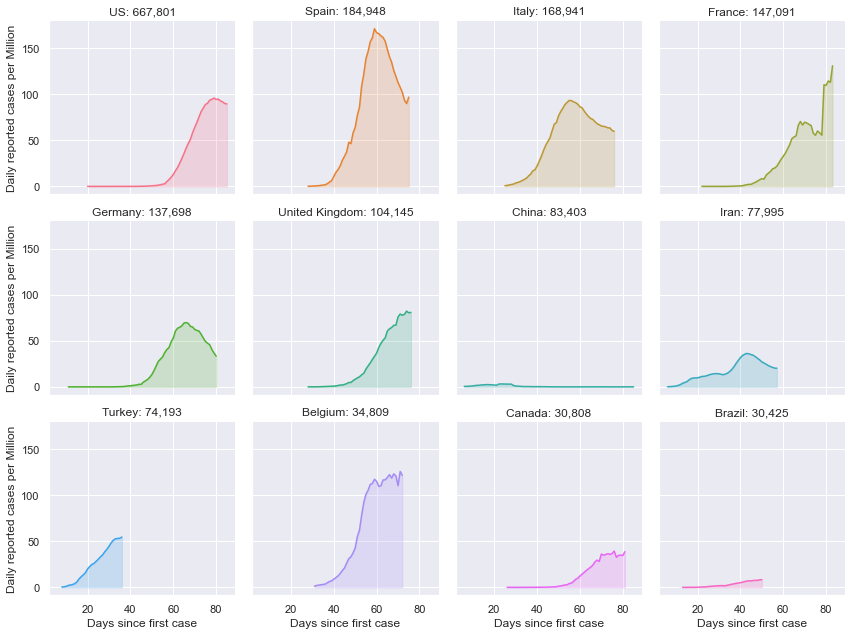

In [9]:
# New daily cases per million inhabitants, 7day rolloing window
plot_grid(confirmed_countries_df, x_label='Days since first case', y_label='Daily reported cases per Million', colname='new_cases_pop_avg')


# Deaths

US: 32917
Spain: 19315
Italy: 22170
France: 17941
Germany: 4083
United Kingdom: 13759
China: 3346
Iran: 4869
Turkey: 1643
Belgium: 4857
Canada: 1257
Brazil: 1924


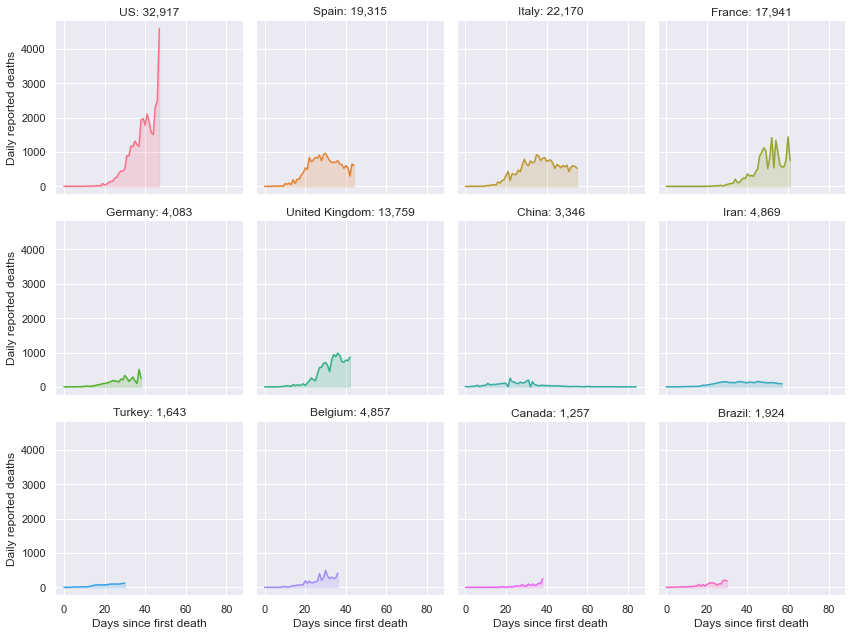

In [10]:
deaths_df = get_jhu_dataset('time_series_covid19_deaths_global.csv')
deaths_countries_df = get_topN_countries(deaths_df, topN_countries_by_total)
plot_grid(deaths_countries_df, x_label='Days since first death', y_label='Daily reported deaths')


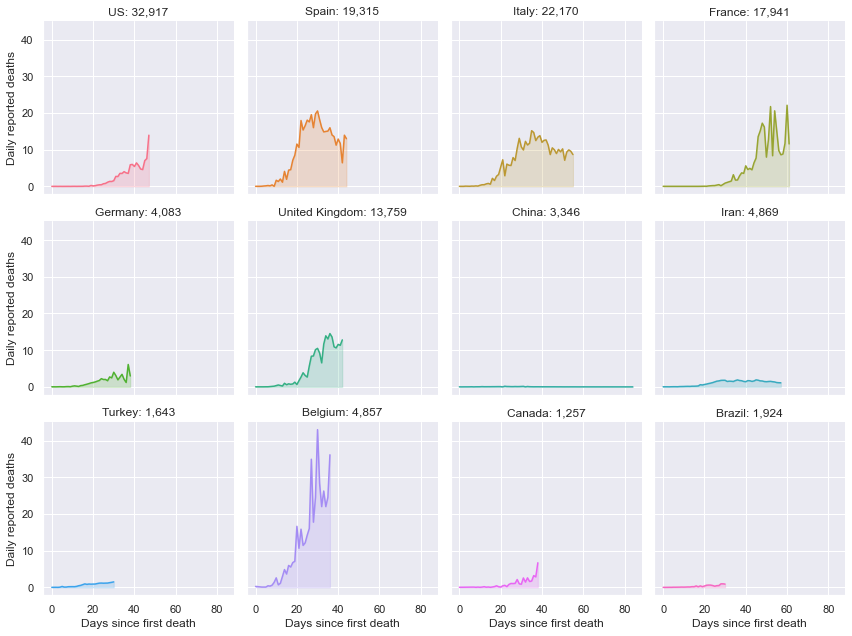

In [11]:
# Deaths by Million inhabitants
plot_grid(deaths_countries_df, x_label='Days since first death', y_label='Daily reported deaths', colname='new_cases_pop')


## Mauritius and friends

Mauritius: 324
Australia: 6462
Seychelles: 11
Maldives: 25


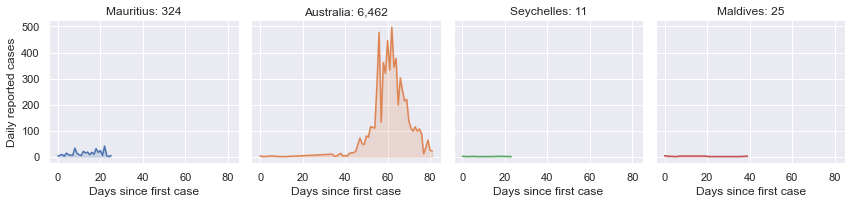

In [12]:
mru_neighbors = ['Mauritius', 'Australia', 'Seychelles', 'Maldives']
confirmed_mru_df = get_topN_countries(confirmed_df, mru_neighbors)
plot_grid(confirmed_mru_df, x_label='Days since first case', y_label='Daily reported cases')


Mauritius: 9
Australia: 63
Seychelles: 0
Maldives: 0


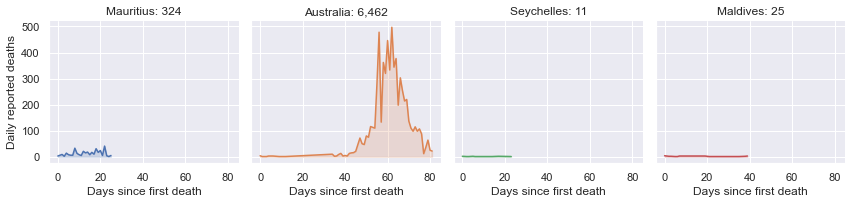

In [13]:
deaths_countries_df = get_topN_countries(deaths_df, mru_neighbors)
plot_grid(confirmed_mru_df, x_label='Days since first death', y_label='Daily reported deaths')


# Infection total, rate, and acceleration

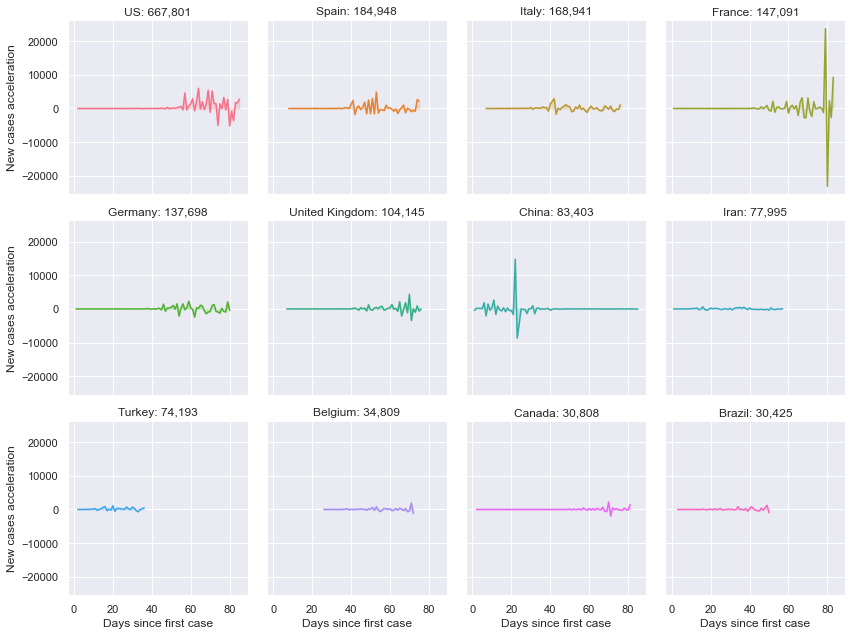

In [21]:
# New daily cases per Million inhabitants
plot_grid(confirmed_countries_df, col_wrap=4, x_label='Days since first case', y_label='New cases acceleration', colname='new_cases_acc')


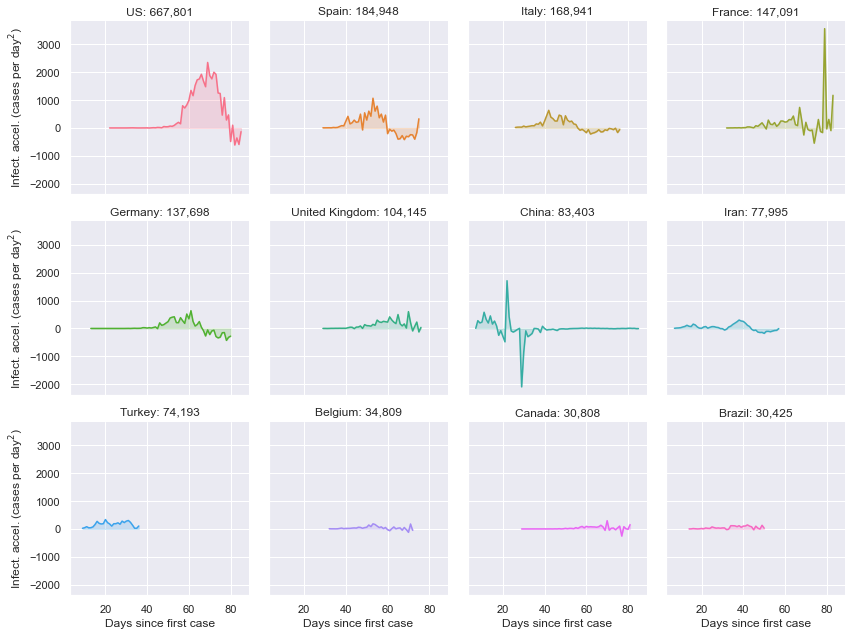

In [22]:
plot_grid(confirmed_countries_df, x_label='Days since first case', y_label='Infect. accel. (cases per day$^2$)', colname='new_cases_avg_acc')


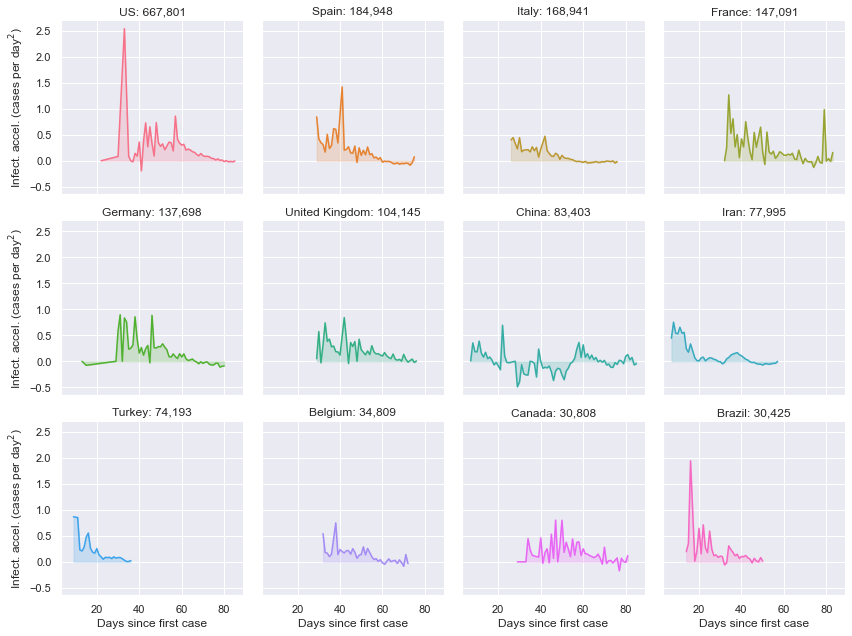

In [31]:
plot_grid(confirmed_countries_df, x_label='Days since first case', y_label='Infect. accel. (cases per day$^2$)', colname='new_cases_avg_acc_pct')


# Sweden

Sweden: 12540
US: 667801


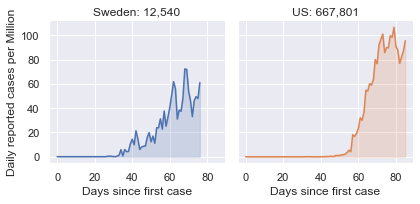

In [16]:
confirmed_sweden_df = get_topN_countries(confirmed_df, ['Sweden', 'US'])
plot_grid(confirmed_sweden_df, col_wrap=2, x_label='Days since first case', y_label='Daily reported cases per Million', colname='new_cases_pop')


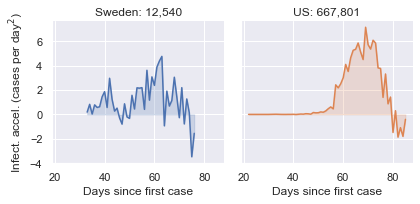

In [17]:
plot_grid(confirmed_sweden_df, col_wrap=2, 
          x_label='Days since first case', y_label='Infect. accel. (cases per day$^2$)', 
          colname='new_cases_avg_acc_pop')
